## Secondary Data Exploration 

- Divide topics by type of visa applied under and reevaulate results. 
- With new results, subdivide into several hypotheses and report results. 
- Determine most deterministic categories, which are irrelevant 

### Types of visas: 

- B1 buisiness 
- B2 vacation
- F1 study 
- H1B temp technical work for graduates 
- E2 Investor 
- TN Preferential for canada/mexico 
- L1 Continuation of old visa 

### Factors not test (no data)

- family ties 
- change over time (data incomplete) 

In [6]:
import pandas as pd 
import numpy as np 
import geopandas as gpd
import matplotlib.pyplot as plt 
%matplotlib inline

In [7]:
visas = pd.read_csv('visas_clean.csv', dtype=str)

status = ['Certified', 'Denied']
types = ['H-1B', 'L-1', 'F-1', 'TN', 'E-2', 'B1B2']

#for reference 
v = {'B1B2' : 'buisiness vacation',
    'F-1' : 'study',
    'H-1B' : 'temp technical work for graduates',
    'E-2' : 'Investor',
    'TN' : 'Preferential for canada/mexico',
    'L-1' :  'Continuation of old visa'}

def percentage(x): 
    total = x[0] + x[1]
    x[0] /= total/100
    x[1] /=total/100 
    return x

def low(x): 
    return x.lower()

In [8]:
def b1b2(x):
    '''combine b1 and b2 into one type'''
    if x == 'B-1' or x == 'B-2': 
        x = 'B1B2'
    return x

visas.class_of_admission = visas.class_of_admission.apply(b1b2)

In [9]:
#only select visa types of interest 
visas = visas[((visas.class_of_admission == types[0])
               | (visas.class_of_admission == types[1])
               | (visas.class_of_admission == types[2])
               | (visas.class_of_admission == types[3])
               | (visas.class_of_admission == types[4])
               | (visas.class_of_admission == types[5]))]
print (visas.shape)
visas.head(3)

(315527, 27)


,case_status,class_of_admission,country_of_citzenship,decision_date,employer_city,employer_decl_info_title,employer_name,employer_num_employees,employer_state,foreign_worker_info_birth_country,...,job_info_work_city,job_info_work_state,naics_2007_us_title,naics_title,pw_job_title_9089,pw_level_9089,wage_offer_from_9089,wage_offer_unit_of_pay_9089,bin_employer_num_employees,title
1,Denied,B1B2,POLAND,12/21/2011,CARLSTADT,U,PINNACLE ENVIRONEMNTAL CORP,-1,NY,NaN,...,New York,NY,Hazardous Waste Treatment and Disposal,NaN,ASBESTOS HANDLER,Level I,37024,yr,NaN,asbestos handler nan hazardous waste treatment...
2,Certified,H-1B,INDIA,12/1/2011,GLEN ALLEN,U,"SCHNABEL ENGINEERING, INC.",-1,VA,NaN,...,Lutherville,MD,Engineering Services,NaN,Civil Engineer,Level I,47923,yr,NaN,civil engineer nan engineering services
3,Certified,B1B2,SOUTH KOREA,12/1/2011,FLUSHING,U,EBENEZER MISSION CHURCH,-1,NY,NaN,...,Flushing,NY,Religious Organizations,NaN,File Clerk,Level II,10.97,hr,NaN,file clerk nan religious organizations


## Country 

- Certification Rates differ largely by country - some countries are significantly more failure prone than others. 
- F1 - Asian countries, South America have lowest rates 
- B1/B2 - India, Russia, Central/South America have lowest rates. 

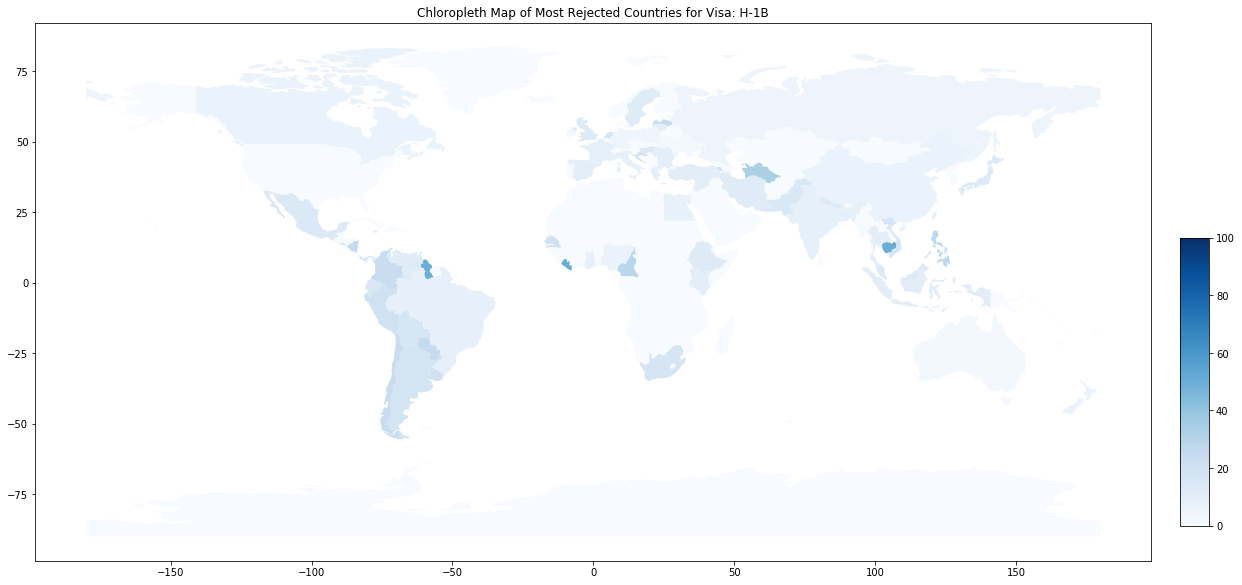

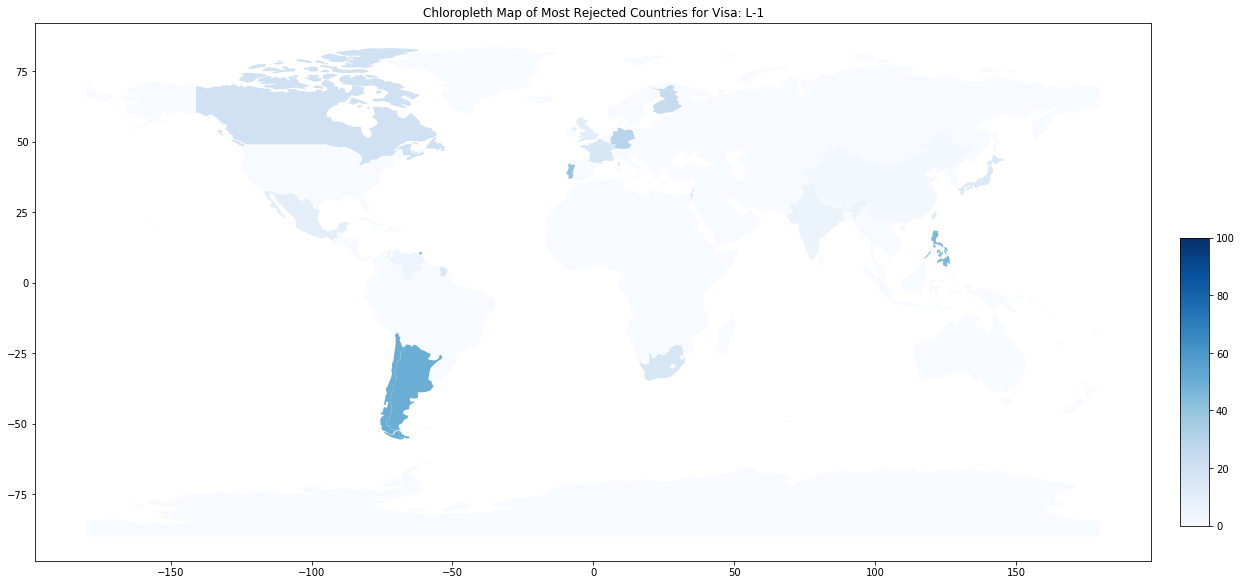

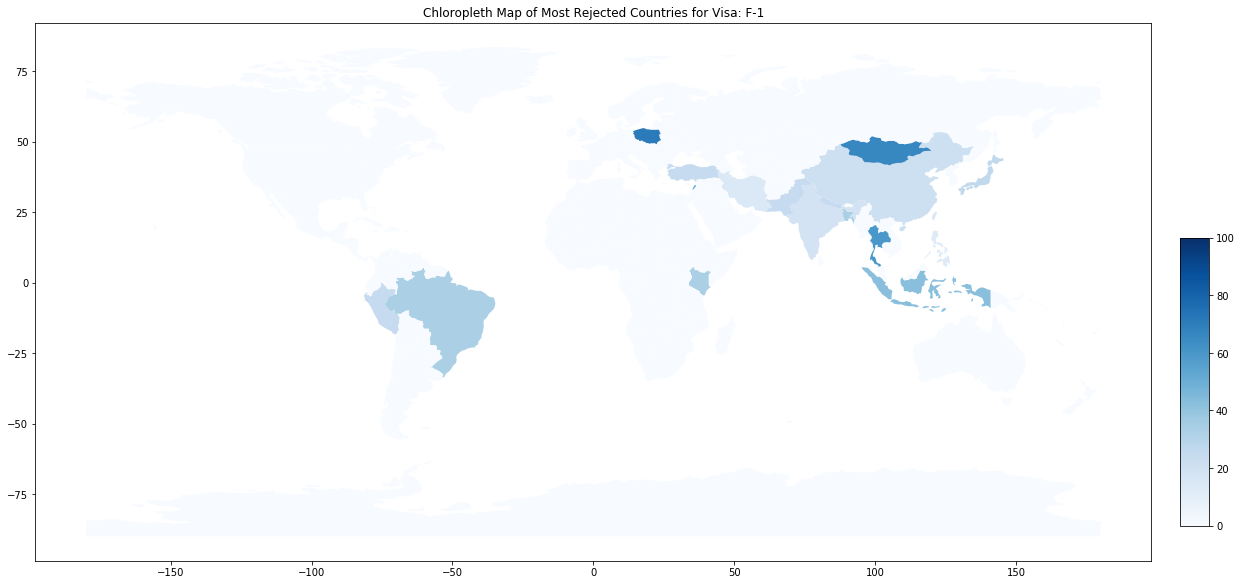

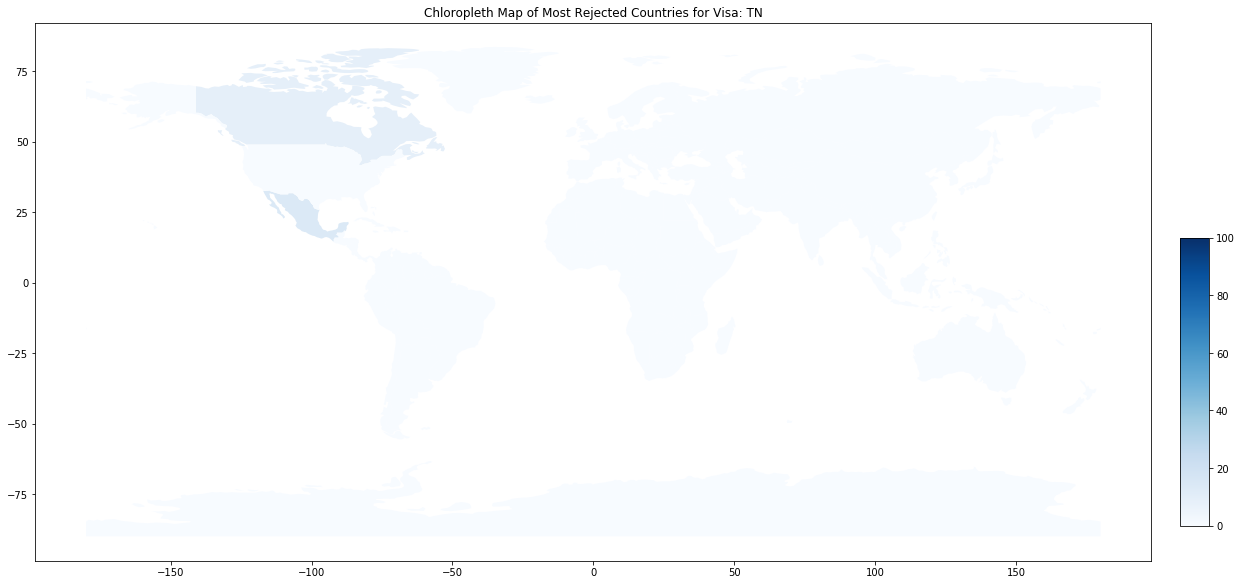

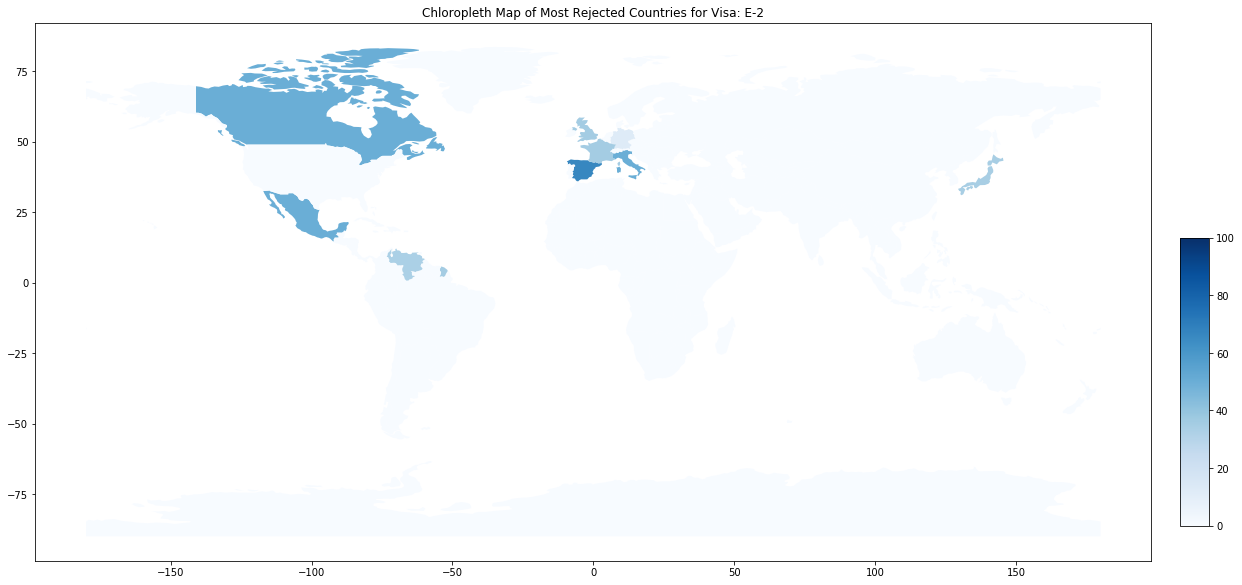

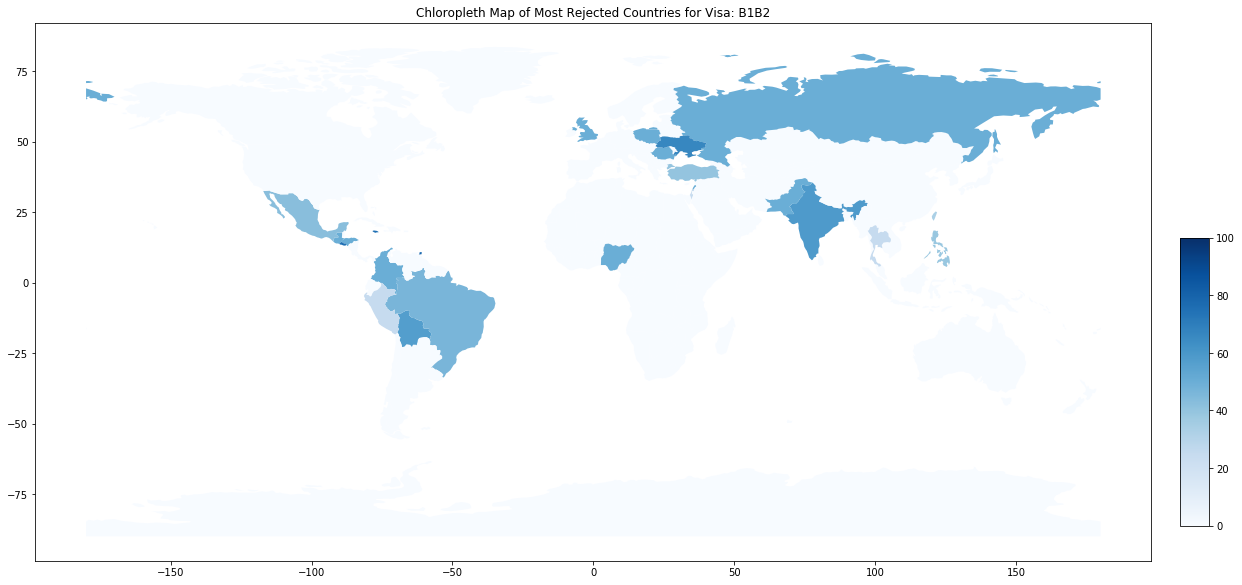

In [110]:
for t in types: 
    temp_df = visas[visas.class_of_admission == t] 

    country = pd.DataFrame([pd.value_counts(temp_df[(temp_df.case_status == status[0])].country_of_citzenship),
                              pd.value_counts(temp_df[(temp_df.case_status == status[1])].country_of_citzenship)],
                             index = status, dtype=float).T
    country = country.dropna()
    country = country.apply(percentage, axis=1)

    '''create a geopandas dataframe merge the visa data & plot '''

    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

    world.loc[world['name']== 'bosnia and herz.', 'name'] = 'bosnia and herzegovina'
    world['name'] = world.name.apply(low)
    world.index = world['name']
    world['status'] = world['pop_est'].copy()

    #update the world df with case status denined/certifed values 
    visa_countries = [x.lower() for x in country.index.values] #format the same 
    country.index = visa_countries
    for co in world['name']: 
        if co not in visa_countries:
            world.loc[co, 'status'] = 0
        else: 
            world.loc[co, 'status'] = country.loc[co, 'Denied']

    #this will not affect the map, except to scale the colors appropriately -- hacky solution 
    world.loc['singapore', 'status'] = 100 

    ##########################################################################3
    #plot 
    ax = world.plot(column='status', cmap='Blues', figsize=(20, 20))

    fig = ax.get_figure()
    plt.title('Chloropleth Map of Most Rejected Countries for Visa: {}'.format(t))

    #plot the colorbar...
    #https://stackoverflow.com/questions/36008648/colorbar-on-geopandas
    cax = fig.add_axes([.92, 0.34, 0.02, 0.2])
    vmin, vmax = 0, 100 #min(country.Denied), max(country.Denied)
    sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm._A = []
    fig.colorbar(sm, cax=cax)

    plt.show()

In [6]:
# country.sort_values('Denied', ascending=False).astype(int).head(20)
# country.sort_values('Certified', ascending=False).astype(int).head(5)

### Company Size 

observations: 
- certification rates increase with company size 
    - p(certification) increases as stability of job increaes (low for startup)
- b-visas (holiday/buisness) lowest acceptance 
- no companies swap positions as company grows 

In [123]:
plt.style.use('fivethirtyeight')

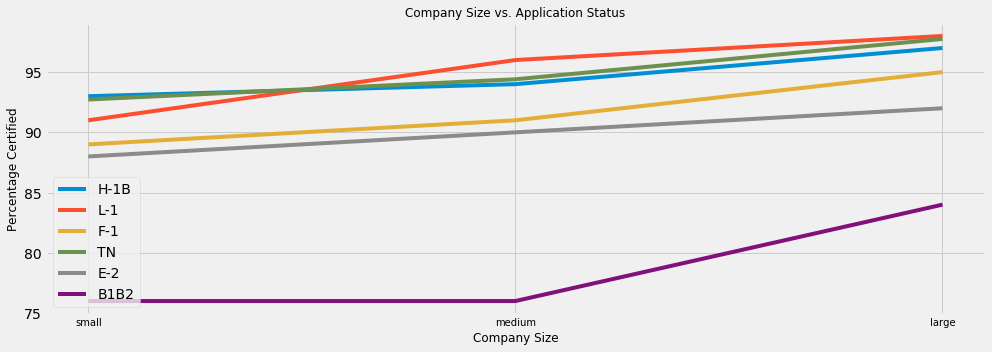

In [124]:
l = []
for t in types: 
    temp_df =  pd.DataFrame([pd.value_counts(visas[(visas.case_status == status[0]) \
                                                   & (visas.class_of_admission == t)].bin_employer_num_employees),
                             pd.value_counts(visas[(visas.case_status == status[1]) \
                                                   & (visas.class_of_admission == t)].bin_employer_num_employees)],
                    index = status).T
    
    temp_df.apply(percentage , axis=1)
    temp_df = temp_df.reindex(['small', 'medium', 'large'])
    temp_df.columns = [t, '_']
    l.append(temp_df[t])
companies = pd.concat(l, axis=1)

## plot ####################################
plt.figure()
companies.plot.line(figsize=(15,5))

plt.ylabel('Percentage Certified', fontsize=12)
plt.xlabel('Company Size', fontsize=12)
plt.title('Company Size vs. Application Status', fontsize=12)
plt.xticks(range(len(companies.index)), list(companies.index), fontsize=10)
plt.legend()
plt.show()

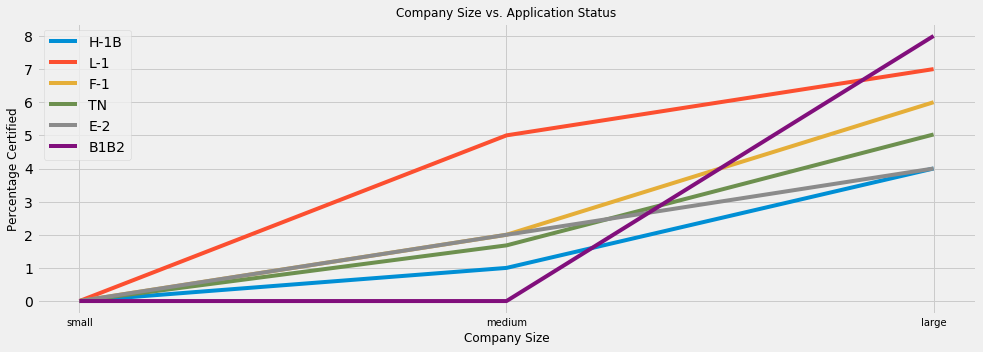

In [125]:
## Normalized ##############################
## plot ####################################
plt.figure()
companies_norm = companies- companies.loc['small']
companies_norm.plot.line(figsize=(15,5))

plt.ylabel('Percentage Certified', fontsize=12)
plt.xlabel('Company Size', fontsize=12)
plt.title('Company Size vs. Application Status', fontsize=12)
plt.xticks(range(len(companies.index)), list(companies.index), fontsize=10)
plt.legend()
plt.show()

### Max Degree Earned 

- more degrees post-high-school correlate to higher probality of getting certified

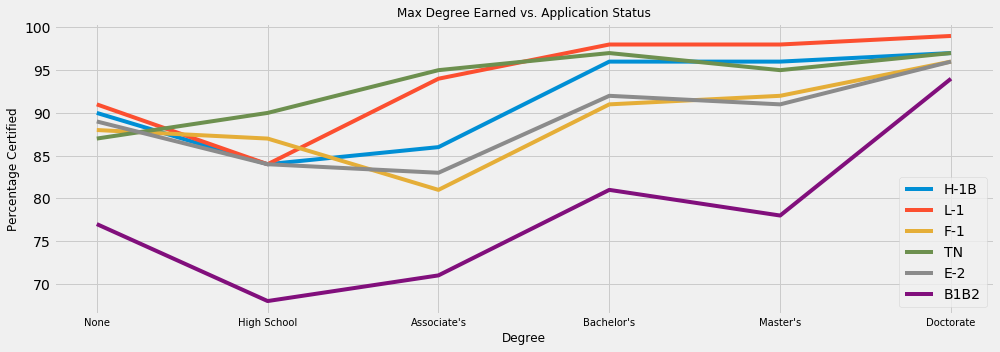

In [126]:
l = []
for t in types: 
    temp_df =  pd.DataFrame([pd.value_counts(visas[(visas.case_status == status[0]) \
                                                   & (visas.class_of_admission == t)].foreign_worker_info_education),
                             pd.value_counts(visas[(visas.case_status == status[1]) \
                                                   & (visas.class_of_admission == t)].foreign_worker_info_education)],
                    index = status).T
    
    temp_df.apply(percentage , axis=1)
    temp_df = temp_df.reindex(['None', 'High School', 'Associate\'s', 'Bachelor\'s', 'Master\'s', 'Doctorate'])
    temp_df.columns = [t, '_']
    l.append(temp_df[t])
degrees = pd.concat(l, axis=1)

# ## plot ####################################
plt.figure()


degrees.plot(kind='line',figsize=(15,5),
#              xticks=list(degrees.index)
            )

plt.ylabel('Percentage Certified', fontsize=12)
plt.xlabel('Degree', fontsize=12)
plt.xticks(range(len(degrees.index)), list(degrees.index), fontsize=10)
plt.title('Max Degree Earned vs. Application Status', fontsize=12)
plt.legend()
plt.show()

### Level of Job Experience 

- no correlations 

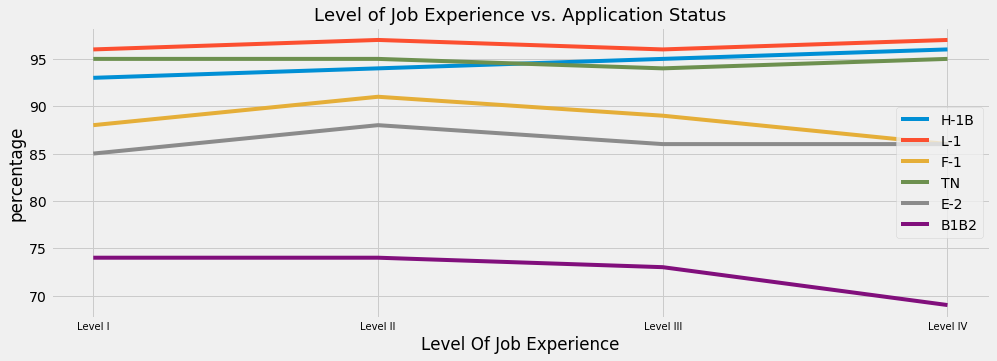

In [127]:
l = []
for t in types: 
    temp_df =  pd.DataFrame([pd.value_counts(visas[(visas.case_status == status[0]) \
                                                   & (visas.class_of_admission == t)].pw_level_9089),
                             pd.value_counts(visas[(visas.case_status == status[1]) \
                                                   & (visas.class_of_admission == t)].pw_level_9089)],
                    index = status).T
    
    temp_df.apply(percentage , axis=1)
    temp_df.columns = [t, '_']
    l.append(temp_df[t])
levels = pd.concat(l, axis=1)

plt.figure() 
levels.plot.line(figsize=(15, 5))

plt.xlabel('Level Of Job Experience')
plt.ylabel('percentage')
plt.title('Level of Job Experience vs. Application Status', fontsize=18)
plt.xticks(range(len(levels.index)), list(levels.index), fontsize=10)
plt.legend(loc=7)
plt.show()

### Months of Work Experience 
- Except for B and F visas, there is no correlation with job experience and certification 
- F1 and B1/B2 both see decreases in certifications after 5 years of work experience 
    - since F is for studying, it could be that these students suffer from age-bias

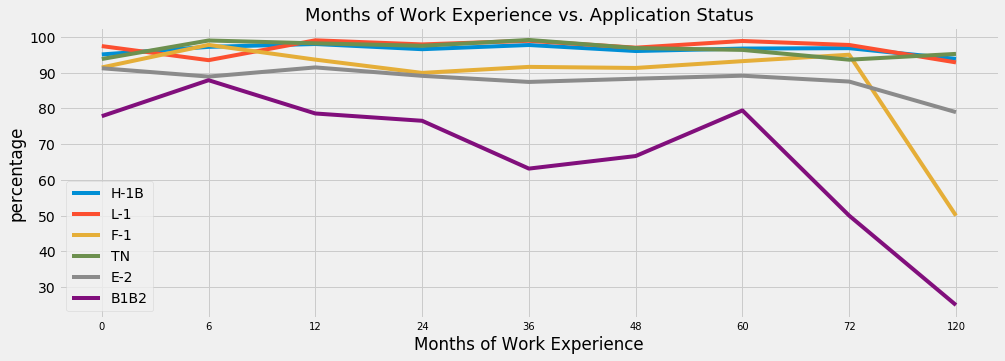

In [128]:
l = []
for t in types: 
    temp_df =  pd.DataFrame([pd.value_counts(visas[(visas.case_status == status[0]) \
                                                   & (visas.class_of_admission == t)].job_info_experience_num_months),
                             pd.value_counts(visas[(visas.case_status == status[1]) \
                                                   & (visas.class_of_admission == t)].job_info_experience_num_months)],
                    index = status).T
    
    temp_df.apply(percentage , axis=1)
    temp_df.columns = [t, '_']
    l.append(temp_df[t])
time_exp = pd.concat(l, axis=1)
time_exp = time_exp.reindex(np.array(sorted(time_exp.index.values.astype(int))).astype(str))
time_exp = time_exp.dropna()

plt.figure() 
time_exp.plot(figsize=(15, 5))
plt.xlabel('Months of Work Experience')
plt.ylabel('percentage')
plt.title('Months of Work Experience vs. Application Status', fontsize=18)
plt.xticks(range(len(time_exp.index)), list(time_exp.index), fontsize=10)
plt.legend()
plt.show()

## Wages 

- For all categories except B1B2, wages are gaussian distributions 
- Probability Distributions follow eachother, which means that no affect of wage on certification.  
- For all wages, means are slightly higher for Certified, but within one standard deviation 
- B1/B2's earn almost half that (40/46k) compared to other visa types (~80-100k)

#### Finding: An increase in wage does not mean in increase in probablity of getting approved for any visa. 


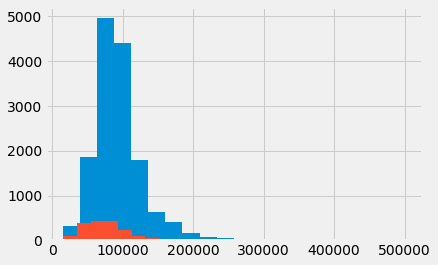

In [129]:
temp_df = visas[visas.wage_offer_unit_of_pay_9089 == 'Year']

cert_temp = temp_df[temp_df.case_status == status[0]]
den_temp = temp_df[temp_df.case_status == status[1]]

cert_temp = cert_temp.wage_offer_from_9089.astype(float).sort_values()[:-5]
cert_temp.hist(bins=20)

den_temp = den_temp.wage_offer_from_9089.astype(float).sort_values()[:-5]
den_temp.hist(bins=20)

plt.show()

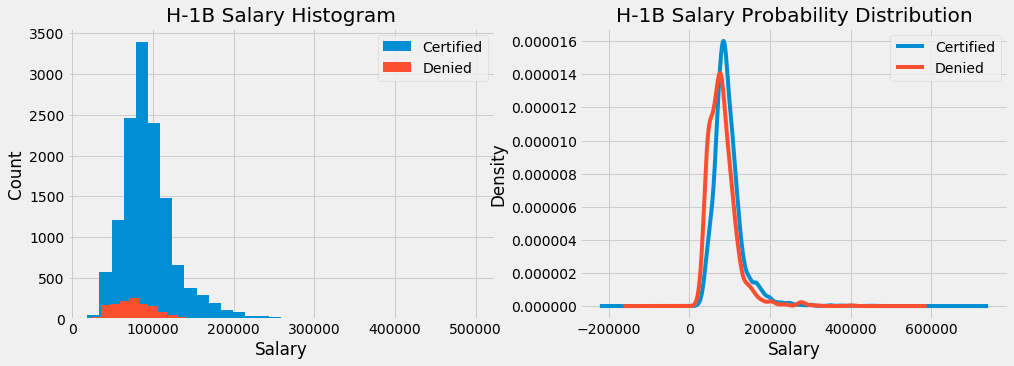

H-1B 
                    mean           std
Certified  95847.006750  37795.132768
Denied     81374.245126  36454.896243


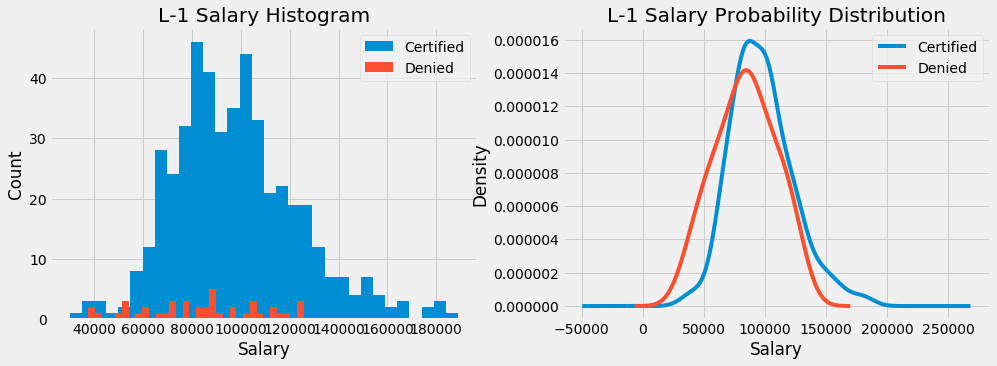

L-1 
                    mean           std
Certified  97768.805178  25887.328517
Denied     83986.714286  24454.226445


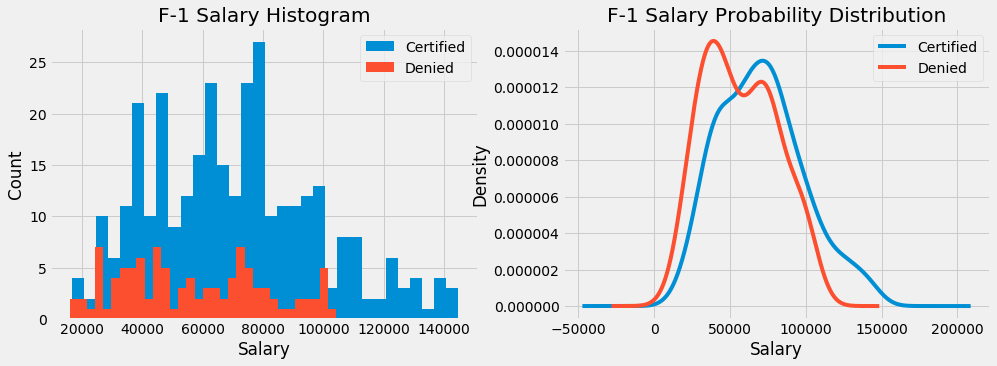

F-1 
                    mean           std
Certified  70619.773117  27984.507696
Denied     56972.906796  23692.102625


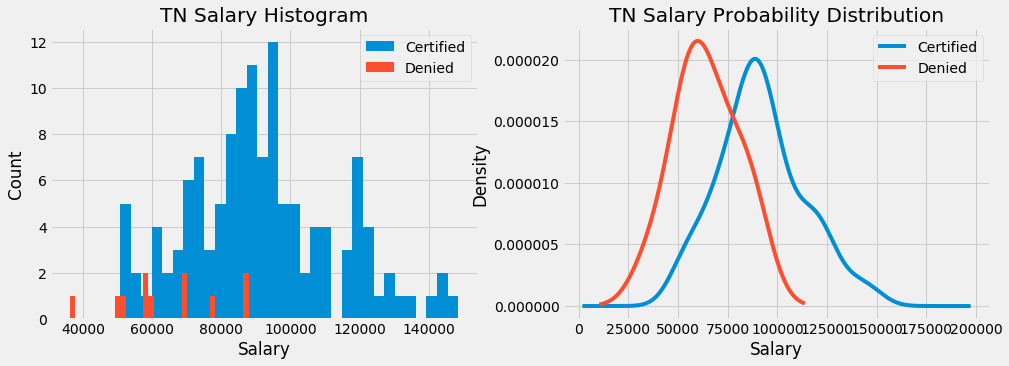

TN 
                    mean           std
Certified  91632.257984  21536.046569
Denied     64237.280000  15931.719506


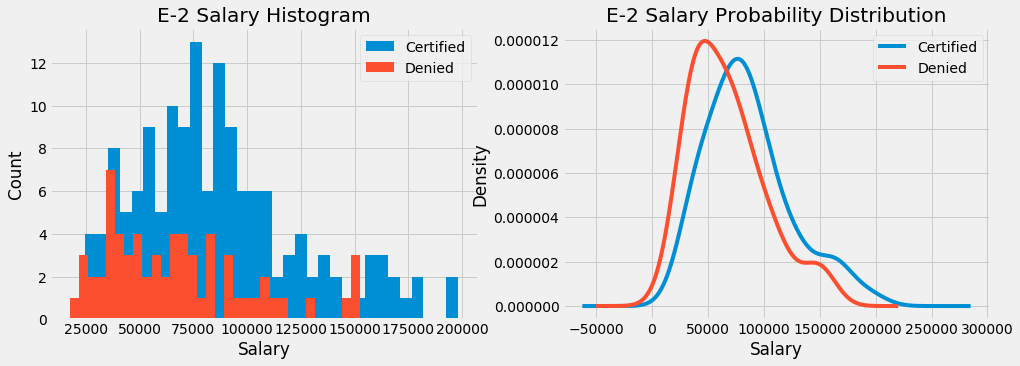

E-2 
                    mean           std
Certified  86053.983784  38363.503118
Denied     67177.665625  33589.425513


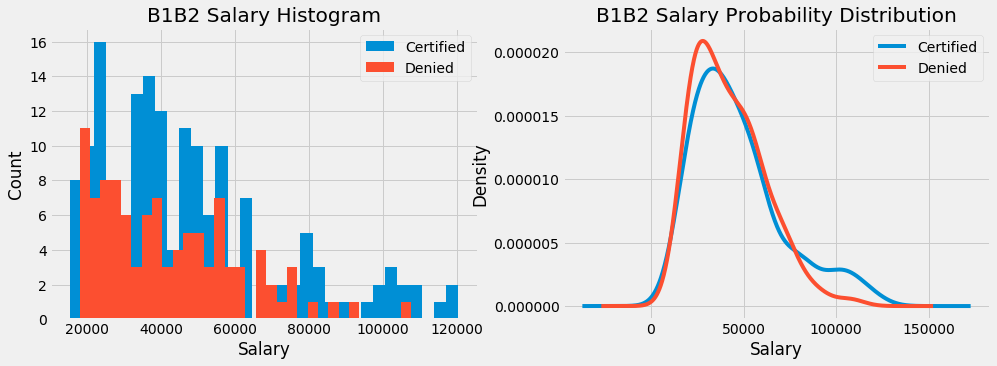

B1B2 
                    mean           std
Certified  46996.515060  24415.505080
Denied     42070.815534  18965.381251


In [163]:
for t in types: 
    plt.figure(figsize = (15, 5))
    plt.subplot(1, 2, 1)
     
    temp_df = visas[(visas.wage_offer_unit_of_pay_9089 == 'Year')\
                     &(visas.class_of_admission == t) ]
    cert_temp = temp_df[temp_df.case_status == status[0]]
    den_temp = temp_df[temp_df.case_status == status[1]]
    
    cert_temp = cert_temp.wage_offer_from_9089.astype(float).sort_values()[:-5]
    cert_temp.hist(bins=32, label='Certified')

    den_temp = den_temp.wage_offer_from_9089.astype(float).sort_values()[:-5]
    den_temp.hist(bins=32, label='Denied')

    plt.title('{} Salary Histogram'.format(t))
    plt.xlabel('Salary')
    plt.ylabel('Count')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    cert_temp.plot(kind='kde', label='Certified')
    den_temp.plot(kind='kde', label='Denied')
    plt.title('{} Salary Probability Distribution'.format(t))
    plt.xlabel('Salary')
    plt.legend()
    plt.show()
    
    values = pd.DataFrame([[cert_temp.mean(), cert_temp.std()], 
                      [den_temp.mean(), den_temp.std()]],
                      columns = ['mean', 'std'], 
                     index = ['Certified', 'Denied'])
    print (t, '\n', values)


In [55]:
v

{'B1B2': 'buisiness vacation',
 'E-2': 'Investor',
 'F-1': 'study',
 'H-1B': 'temp technical work for graduates',
 'L-1': 'Continuation of old visa',
 'TN': 'Preferential for canada/mexico'}

In [ ]:
visas[visas.wage_offer_unit_of_pay_9089 == 'Year'].wage_offer_from_9089.astype(float)    .sort_values()    .hist

## Wage Units(Yr/Hr)
- Hourly wage has lower acceptance rates for all visa types. 

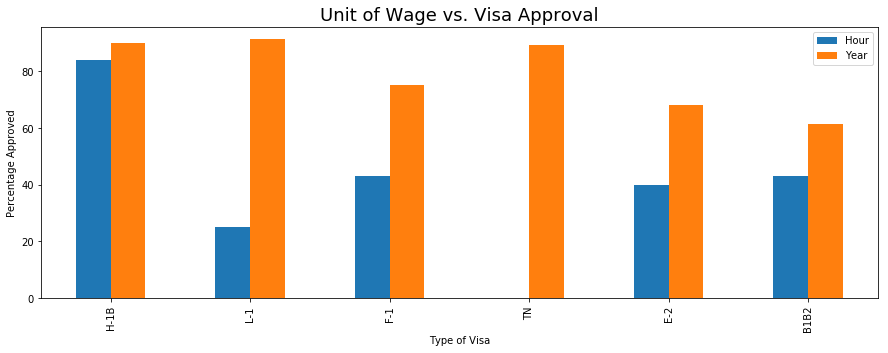

,H-1B,L-1,F-1,TN,E-2,B1B2
Hour,84,25.000000,43.0,NaN,40.0,43.103448
Year,90,91.115312,75.0,89.333333,68.0,61.290323


In [6]:
if ('run' not in vars()): 
    visas['wage_offer_unit_of_pay_9089'] = visas['wage_offer_unit_of_pay_9089'].map(
        {'yr': 'Year',
         'hr': 'Hour', 
         'wk' : 'Week',
         'mth' : 'Month', 
       })
    run = True

l = []
for t in types: 
    temp_df =  pd.DataFrame([pd.value_counts(visas[(visas.case_status == status[0]) \
                                                   & (visas.class_of_admission == t)].wage_offer_unit_of_pay_9089),
                             pd.value_counts(visas[(visas.case_status == status[1]) \
                                                   & (visas.class_of_admission == t)].wage_offer_unit_of_pay_9089)],
                    index = status).T
    
    temp_df.apply(percentage , axis=1)
    temp_df.columns = [t, '_']
    l.append(temp_df[t])
wages = pd.concat(l, axis=1)
wages.drop(['Month', 'Week'], inplace=True)

plt.figure()
wages.T.plot.bar(figsize=(15, 5))
plt.title('Unit of Wage vs. Visa Approval', fontsize=18)
plt.xlabel('Type of Visa')
plt.ylabel('Percentage Approved')
plt.show()

wages

## Dates 

- looks like there is missing data -- inconclusive 

In [135]:
def date(x): 
    return x.split('/')[-1]
    
visas['dates_applied'] = visas.decision_date.apply(date)

2016    1303
2015     980
2014     557
2013     426
2012     353
2011     136
Name: dates_applied, dtype: int64

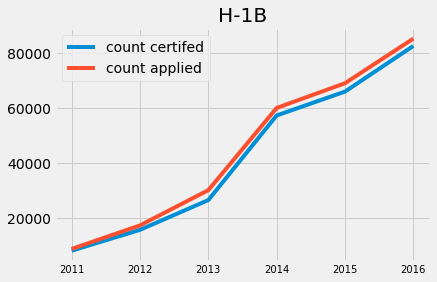

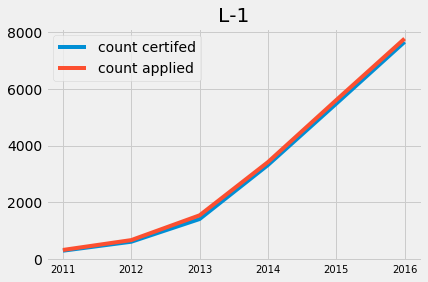

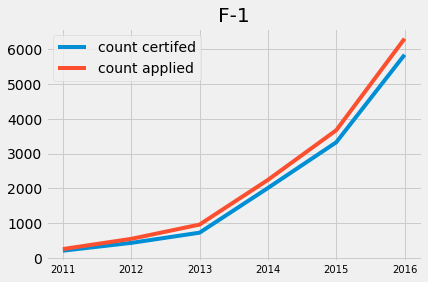

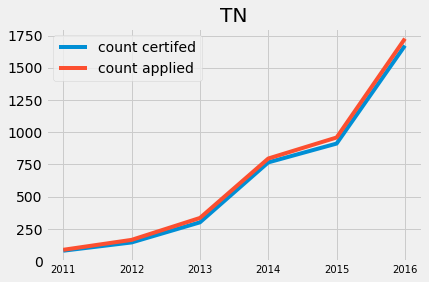

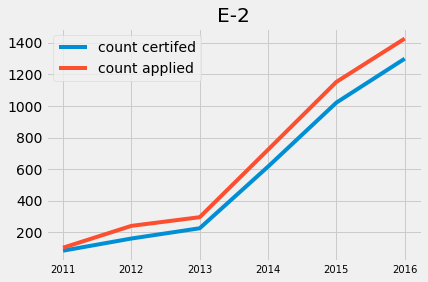

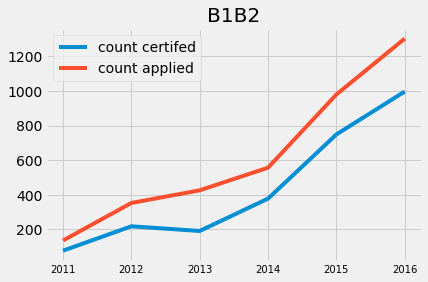

In [162]:
for t in types: 
    dates = visas.dates_applied[(visas.class_of_admission == t) & \
                               (visas.case_status == status[0])]
    dates = pd.value_counts(dates)
    counts = pd.value_counts(visas.dates_applied[visas.class_of_admission == t])
#     last_year 
    dates = dates.sort_index(ascending=True)
    
    df = pd.DataFrame([dates, counts], index = ['count certifed', 'count applied']).T
    df.plot()
    plt.xticks(range(len(df.index)), list(df.index), fontsize=10)
    plt.title(t)
    plt.show()
#     dates.plot(figsize=(15, 5), label=t)
#     plt.title('Visas Applied Per Year')
#     plt.legend()
    
# plt.show()

## Job Title 

In [10]:
import string 

#grab all work titles, push into single vector, clean 

def word_vec(case, visa_type): 
    selection = visas.title[(visas.case_status == case) \
                           & (visas.class_of_admission == visa_type)]
    word_vec = selection.values.flatten()
    words = ' '.join(word_vec).split()

    #remove punctation/symbols s
    for i in range(len(words)): 
        go = False 
        while not go: 
            for char in string.punctuation: 
                if char in words[i]: 
                    words[i] = words[i].replace(char, '')
                else: 
                    go = True

    #remove nans, blanks we generated
    words = np.array(words)
    words = words[words != 'nan']
    words = words[words != '']
    words = list(words)

    #value counts 
    return pd.value_counts(pd.DataFrame(words)[0])

In [13]:
for t in types: 
    #generate the word counts 
    words_certified_orig = word_vec(status[0], t)
    words_denied_orig = word_vec(status[1], t)

    #drop less than 5 applicants of the job 
    words_certified_orig = words_certified_orig[words_certified_orig > 5]
    words_denied_orig = words_denied_orig [words_denied_orig > 5]

    #normalize 
    words_certified = words_certified_orig/visas[visas.case_status == status[0]].shape[0]
    words_denied = words_denied_orig/visas[visas.case_status == status[1]].shape[0]

    #build data frame 
    words_ratio = pd.concat([words_certified, words_denied, words_certified_orig, words_denied_orig], axis=1)
    words_ratio.columns = ['Certified', 'Denied', 'Certified_count', 'Denied_count']
    words_ratio = words_ratio.dropna()

    #create ratio 
    words_ratio['ratio'] = words_ratio.Certified/words_ratio.Denied

    #show results 
    print (t)
#     print ('where rejection is higher than approval', 
#            list(words_ratio[words_ratio.Certified_count < words_ratio.Denied_count].index), 
#           '\n')
    print ('ratio list best', 
           list(words_ratio.sort_values('ratio', ascending=False).head(10).index),
           '\n')
    print ('ratio list worst', 
           list(words_ratio.sort_values('ratio', ascending=True).head(10).index),
           '\n')
    print ()

H-1B
ratio list best ['portals', 'dealing', 'radio', 'search', 'banking', 'securities', 'oil', 'surgeons', 'electric', 'broadcasting'] 

ratio list worst ['engineersapplications', 'teacher', 'programmeranalyst', 'math', 'supervisorsmanagers', 'bilingual', 'mechanics', 'high', 'costume', 'middle'] 


L-1
ratio list best ['electronic', 'design', 'publishers', 'developers', 'semiconductor', 'services', 'except', 'applications', 'wireless', 'financial'] 

ratio list worst ['professional', 'oil', 'training', 'transportation', 'for', 'technicians', 'operations', 'support', 'gas', 'all'] 


F-1
ratio list best ['semiconductor', 'electronic', 'component', 'electronics', 'manufacturing', 'engineers', 'dentists', 'software', 'developers', 'engineering'] 

ratio list worst ['hotels', 'programmers', 'junior', 'agencies', 'special', 'cutters', 'foreign', 'workers', 'service', 'mental'] 


TN
ratio list best ['software', 'applications', 'manufacturing', 'analysts', 'systems', 'computer', 'and', 'eng

In [14]:
words_ratio.head()

,Certified,Denied,Certified_count,Denied_count,ratio
accountant,0.000057,0.000330,17.0,6.0,0.173262
accountants,0.000175,0.000880,52.0,16.0,0.198742
accounting,0.000104,0.000385,31.0,7.0,0.270813
administrative,0.000091,0.001430,27.0,26.0,0.063503
aides,0.000266,0.003135,79.0,57.0,0.084754


In [105]:
def word_vec2(case, visa_type): 
    selection = visas.naics_2007_us_title[(visas.case_status == case) \
                           & (visas.class_of_admission == visa_type)]
    return pd.value_counts(selection)

for t in types: 

    #generate the word counts 
    words_certified_orig = word_vec2(status[0], t)
    words_denied_orig = word_vec2(status[1], t)

    #drop less than 5 applicants of the job 
    words_certified_orig = words_certified_orig[words_certified_orig > 2]
    words_denied_orig = words_denied_orig [words_denied_orig > 2]

    #normalize 
    words_certified = words_certified_orig/visas[visas.case_status == status[0]].shape[0]
    words_denied = words_denied_orig/visas[visas.case_status == status[1]].shape[0]

    #build data frame 
    words_ratio = pd.concat([words_certified, words_denied, words_certified_orig, words_denied_orig], axis=1)
    words_ratio.columns = ['Certified', 'Denied', 'Certified_count', 'Denied_count']
    words_ratio = words_ratio.dropna()

    #create ratio 
    words_ratio['ratio'] = words_ratio.Certified/words_ratio.Denied

    #show results 
    print (t, v[t])
    print ('where rejection is higher than approval', 
           list(words_ratio[words_ratio.Certified_count < words_ratio.Denied_count].index), 
          '\n')
    print ('ratio list best', 
           list(words_ratio.sort_values('ratio', ascending=False).head(10).index),
           '\n')
    print ('ratio list worst', 
           list(words_ratio.sort_values('ratio', ascending=True).head(10).index),
           '\n')
    print ()

H-1B temp technical work for graduates
where rejection is higher than approval [] 

ratio list best ['Radio and Television Broadcasting and Wireless Communications Equipment Manufacturing', 'Investment Banking and Securities Dealing', 'Administrative Management and General Management Consulting Services', 'Electronic Shopping', 'Commercial Banking', 'Colleges, Universities, and Professional Schools', 'Other Computer Peripheral Equipment Manufacturing', 'Semiconductor and Related Device Manufacturing', 'Software Publishers', 'Portfolio Management'] 

ratio list worst ['Educational Services', "Men's and Boys' Clothing and Furnishings Merchant Wholesalers", 'Elementary and Secondary Schools', 'Supermarkets and Other Grocery (except Convenience) Stores', 'Electromedical and Electrotherapeutic Apparatus Manufacturing', 'Offices of Chiropractors', 'Full-Service Restaurants', 'Other Miscellaneous Nondurable Goods Merchant Wholesalers', 'Freight Transportation Arrangement', 'Administration of 